# Classification with Recurrent Networks
__author__: Pierre Nugues

In this program, we encode the words with embeddings (GloVe)

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import regex as re

from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

from torchtext.datasets import IMDB

In [2]:
random.seed(1234)
torch.manual_seed(1234)

In [3]:
MAX_LENGTH = 150
EPOCHS = 40
LSTM_HIDDEN_DIM = 32
LSTM_LAYERS = 1
DROPOUT = 0.20
EMB_LARGE = False
FREEZE_EMBS = True

## Embeddings

### Reading the embeddings

In [4]:
if EMB_LARGE:
    embedding_file = '/Users/pierre/Documents/Cours/EDAN20/corpus/glove.6B.100d.txt'
    EMBEDDING_DIM = 100
else:
    embedding_file = '/Users/pierre/Documents/Cours/EDAN20/corpus/glove.6B.50d.txt'
    EMBEDDING_DIM = 50

The function below that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embedding vectors.

In [5]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = torch.FloatTensor(list(map(float, values[1:])))
        embeddings[word] = vector
    glove.close()
    return embeddings

In [6]:
# We read the embeddings
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))

In [7]:
'# words in embedding dictionary: {}'.format(len(embedded_words))

'# words in embedding dictionary: 400000'

### Understanding the embeddings

In [8]:
embedded_words[100000:100010]

['chording',
 'chordoma',
 'chordophones',
 'chords',
 'chore',
 'chorea',
 'chorene',
 'choreograph',
 'choreographed',
 'choreographer']

In [9]:
embeddings_dict['chords'][:20]

tensor([-0.4040, -0.0786, -0.2163, -0.2406, -0.2300,  1.0956,  0.9115,  0.7881,
        -0.9250,  1.1640, -0.1718,  0.5499, -0.5291,  1.0982, -1.1583, -0.4945,
        -0.5830, -0.6904,  0.4173, -0.8306])

## Dataset

We create iterators for the IMDB dataset. See here for an example: https://pytorch.org/text/stable/datasets.html#text-classification.

In [10]:
train_iter, test_iter = IMDB(root='imdb')

In [11]:
train_list_complete = list(train_iter)
test_list = list(test_iter)

In [12]:
len(train_list_complete), len(test_list)

(25000, 25000)

In [13]:
random.shuffle(train_list_complete)

We extract a validation set from the training set.

In [14]:
train_list = train_list_complete[:20000]
val_list = train_list_complete[-5000:]

In [15]:
train_list[:3]

[(1,
  "David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicated situations, and so does the perspective of the viewer.<br /><br />So is 'Homicide' which from the title tries to set the mind of the viewer to the usual crime drama. The principal characters are two cops, one Jewish and one Irish who deal with a racially charged area. The murder of an old Jewish shop owner who proves to be an ancient veteran of the Israeli Independence war triggers the Jewish identity in the mind and heart of the Jewish detective.<br /><br />This is were the flaws of the film are the more obvious. The process of awakening is theatrical and hard to believe, the group of Jewish militants is operatic, and the way the detective eventually walks to the final violent confrontation is pathetic. The end of the film itself is Mamet-like smart,

We create a tokenizer

In [16]:
def tokenize(text, lc=True):
    if lc:
        return re.findall('\p{L}+', text.lower())
    else:
        return re.findall('\p{L}+', text)

We extract the inputs and outputs and we set the first class to 0 and the second to 1 as requested by PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [17]:
def extract_io(dataset_list):
    y, corpus = zip(*dataset_list)
    y = [item - 1 for item in y]
    corpus = list(map(tokenize, corpus))
    return y, corpus

In [18]:
y_train, train_corpus = extract_io(train_list)
y_val, val_corpus = extract_io(val_list)
y_test, test_corpus = extract_io(test_list)

In [19]:
len(train_corpus), len(y_train)

(20000, 20000)

In [20]:
len(val_corpus), len(y_val)

(5000, 5000)

In [21]:
len(test_corpus), len(y_test)

(25000, 25000)

In [22]:
train_label_cnt = Counter(y_train)
train_label_cnt

Counter({0: 10024, 1: 9976})

In [23]:
test_label_cnt = Counter(y_test)
test_label_cnt

Counter({0: 12500, 1: 12500})

## Vocabulary

In [24]:
full_text_train = [word for text in train_corpus for word in text]

In [25]:
voc_train_all = list(set(full_text_train))

In [26]:
len(voc_train_all)

67136

In [27]:
cnt_words = Counter(full_text_train)

In [28]:
voc_train = voc_train_all

In [29]:
vocabulary_words = sorted(list(set(embedded_words + voc_train)))

In [30]:
print('# words in the vocabulary: embeddings and corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and corpus: 411324


We reserve pad and unk

In [31]:
idx2word = {k: v for k, v in enumerate(vocabulary_words, start=2)}
word2idx = {v: k for k, v in idx2word.items()}

## Embedding Matrix

We create a torch matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary at respectively index 0 and 1. 

We initialize the matrix with random values with the `torch.rand()`

In [32]:
# We add two dimensions for the padding symbol at index 0 and unknown words at index 1
embedding_matrix = torch.rand((len(vocabulary_words) + 2, EMBEDDING_DIM))/10 - 0.05 # range: -0.05, 0.05, 
# embedding_matrix = torch.rand((len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = torch.zeros((len(vocabulary_words) + 2, EMBEDDING_DIM))

The shape of the matrix is: (411326, 100) or (411326, 50)

In [33]:
embedding_matrix.shape

torch.Size([411326, 50])

We fill the matrix with the GloVe embeddings when available. This means: We replace the random vector with an embedding when available. We will use the indices from the previous section. We call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [34]:
out_of_embeddings = []
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_matrix[word2idx[word]] = embeddings_dict[word]
    else:
        # Otherwise, it keeps a random value in the matrix
        # We store the out of vocabulary words
        out_of_embeddings += [word]

In [35]:
len(out_of_embeddings)

11324

In [36]:
out_of_embeddings[-10:]

['äänekoski',
 'æsthetic',
 'ème',
 'écran',
 'éme',
 'étc',
 'évery',
 'ísnt',
 'østbye',
 'üvegtigris']

Embeddings of the padding symbol, idx 0, random numbers

In [37]:
embedding_matrix[0][:10]

tensor([-0.0471, -0.0098, -0.0240, -0.0133, -0.0442,  0.0201, -0.0448, -0.0032,
         0.0174, -0.0169])

Embeddings of the word _table_, the GloVe values

In [38]:
embedding_matrix[word2idx['table']][:10]

tensor([-0.3666,  1.0584, -0.6538,  0.1767,  1.0605, -0.7254, -0.0097,  0.0797,
        -0.4649, -0.7435])

Embeddings of _äänekoski_, a word in IMDB, but not in GloVe, random numbers

In [39]:
embedding_matrix[word2idx['äänekoski']][:10]

tensor([-0.0145,  0.0470,  0.0328, -0.0477, -0.0344, -0.0359,  0.0459, -0.0239,
         0.0144,  0.0195])

## Word Indices
We format the dataset

In [40]:
X_train_idx = [torch.LongTensor(list(map(lambda x: word2idx.get(x, 1), text[:MAX_LENGTH]))) 
               for text in train_corpus]
X_val_idx = [torch.LongTensor(list(map(lambda x: word2idx.get(x, 1), text[:MAX_LENGTH]))) 
               for text in val_corpus]
X_test_idx = [torch.LongTensor(list(map(lambda x: word2idx.get(x, 1), text[:MAX_LENGTH]))) 
               for text in test_corpus]

In [41]:
X_train_idx[:3]

[tensor([120073, 238501, 198029,  43011, 388600, 196292,  55048,  43011, 388600,
         380887, 141760, 127399, 184011, 152461, 257647, 187104, 275086, 160950,
         394352, 367089, 277035, 190256, 228233,  75331,  55048, 198789, 334599,
          43011, 334237, 275086, 151802, 399711,  98692, 397907, 289352, 275086,
         227889,  98379,  61225, 367667, 164342, 196829, 108342, 342133,  55048,
         345177, 129589, 367089, 289352, 275086, 367089, 389446,  83676,  83676,
         345177, 198029, 185713, 397395, 158078, 367089, 370572, 375259, 370895,
         334599, 367089, 251368, 275086, 367089, 389446, 370895, 367089, 384927,
         114011, 131796, 367089, 300114,  98692,  59486, 378535, 110940, 277035,
         202477,  55048, 277035, 197750, 397822, 120624, 399711,  43011, 306500,
          98770,  59488, 367089, 259892, 275086,  54592, 276131, 202477, 338466,
         281352, 397822, 301829, 370895,  71932,  54592,  55016, 388727, 275086,
         367089, 198624, 193

In [42]:
X_train_idx_padded = pad_sequence(X_train_idx, batch_first=True)
X_val_idx_padded = pad_sequence(X_val_idx, batch_first=True)
X_test_idx_padded = pad_sequence(X_test_idx, batch_first=True)

In [43]:
X_train_idx_padded[:3]

tensor([[120073, 238501, 198029,  43011, 388600, 196292,  55048,  43011, 388600,
         380887, 141760, 127399, 184011, 152461, 257647, 187104, 275086, 160950,
         394352, 367089, 277035, 190256, 228233,  75331,  55048, 198789, 334599,
          43011, 334237, 275086, 151802, 399711,  98692, 397907, 289352, 275086,
         227889,  98379,  61225, 367667, 164342, 196829, 108342, 342133,  55048,
         345177, 129589, 367089, 289352, 275086, 367089, 389446,  83676,  83676,
         345177, 198029, 185713, 397395, 158078, 367089, 370572, 375259, 370895,
         334599, 367089, 251368, 275086, 367089, 389446, 370895, 367089, 384927,
         114011, 131796, 367089, 300114,  98692,  59486, 378535, 110940, 277035,
         202477,  55048, 277035, 197750, 397822, 120624, 399711,  43011, 306500,
          98770,  59488, 367089, 259892, 275086,  54592, 276131, 202477, 338466,
         281352, 397822, 301829, 370895,  71932,  54592,  55016, 388727, 275086,
         367089, 198624, 193

## Model

In [44]:
class Model(nn.Module):

    def __init__(self, embedding_matrix, lstm_units, nbr_classes, freeze_embs=True, num_layers=1, bidi_lstm=False):
        super().__init__()
        embedding_dim = embedding_matrix.size()[-1]
        self.embeddings = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embs, padding_idx=0)
        self.dropout = nn.Dropout(DROPOUT)
        self.lstm = nn.LSTM(embedding_dim, lstm_units, num_layers=num_layers, 
                            dropout=DROPOUT, batch_first=True, bidirectional=bidi_lstm)
        if not bidi_lstm:
            self.fc = nn.Linear(lstm_units, nbr_classes)
        else:
            # twice the units if bidirectional 
            self.fc = nn.Linear(2*lstm_units, nbr_classes)

    def forward(self, sentence):
        embeds = self.embeddings(sentence)
        embeds = self.dropout(embeds)
        lstm_out, (h_n, c_n) = self.lstm(embeds)
        lstm_last = F.relu(h_n[-1])
        lstm_last = self.dropout(lstm_last)
        logits = self.fc(lstm_last)
        return logits

In [45]:
model = Model(embedding_matrix, LSTM_HIDDEN_DIM, 
              2, 
              freeze_embs=FREEZE_EMBS,
              num_layers=LSTM_LAYERS, 
              bidi_lstm=False)

/Users/pierre/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [46]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

## Torch Datasets
We create the torch datasets

In [47]:
X_train = torch.LongTensor(X_train_idx_padded)
y_train = torch.LongTensor(y_train)

X_val = torch.LongTensor(X_val_idx_padded)
y_val = torch.LongTensor(y_val)

X_test = torch.LongTensor(X_test_idx_padded)
y_test = torch.LongTensor(y_test)

In [48]:
X_train[0].size()

torch.Size([150])

In [49]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [50]:
y_train.size()

torch.Size([20000])

In [51]:
def batch_inference(model, X, batchsize=2048):
    with torch.no_grad():
        partial = []
        for i in range(0, X.shape[0], batchsize):
            partial.append(model(X[i:i+batchsize]))
    
    return torch.vstack(partial)

In [52]:
X_train[:1]

tensor([[120073, 238501, 198029,  43011, 388600, 196292,  55048,  43011, 388600,
         380887, 141760, 127399, 184011, 152461, 257647, 187104, 275086, 160950,
         394352, 367089, 277035, 190256, 228233,  75331,  55048, 198789, 334599,
          43011, 334237, 275086, 151802, 399711,  98692, 397907, 289352, 275086,
         227889,  98379,  61225, 367667, 164342, 196829, 108342, 342133,  55048,
         345177, 129589, 367089, 289352, 275086, 367089, 389446,  83676,  83676,
         345177, 198029, 185713, 397395, 158078, 367089, 370572, 375259, 370895,
         334599, 367089, 251368, 275086, 367089, 389446, 370895, 367089, 384927,
         114011, 131796, 367089, 300114,  98692,  59486, 378535, 110940, 277035,
         202477,  55048, 277035, 197750, 397822, 120624, 399711,  43011, 306500,
          98770,  59488, 367089, 259892, 275086,  54592, 276131, 202477, 338466,
         281352, 397822, 301829, 370895,  71932,  54592,  55016, 388727, 275086,
         367089, 198624, 193

In [53]:
model(X_train[:2])

tensor([[0.0315, 0.0853],
        [0.1186, 0.0367]], grad_fn=<AddmmBackward0>)

In [54]:
#y_train_pred = batch_inference(model, X_train)

## Fitting
We fit the model

In [55]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

In [56]:
# Write your code
for epoch in range(EPOCHS):
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    word_cnt = 0
    batch_cnt = 0
    model.train()
    for X_batch, y_batch in tqdm(dataloader):
        batch_cnt += 1
        Y_batch_pred = model(X_batch)
        loss = loss_fn(Y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        train_accuracy = torch.sum(torch.argmax(batch_inference(model, X_train), dim=-1) == y_train)
        history['accuracy'] += [train_accuracy.item()/y_train.size()[0]]
        history['loss'] += [train_loss/batch_cnt]
        
        y_val_pred = batch_inference(model, X_val)
        val_loss = loss_fn(y_val_pred, y_val)
        history['val_loss'] += [val_loss.item()]
        val_accuracy = torch.sum(torch.argmax(batch_inference(model, X_val), dim=-1) == y_val)
        history['val_accuracy'] += [val_accuracy.item()/y_val.size()[0]]

100%|██████████| 625/625 [00:05<00:00, 109.88it/s]


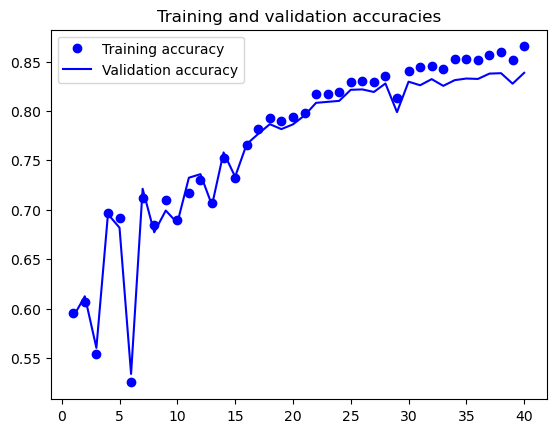

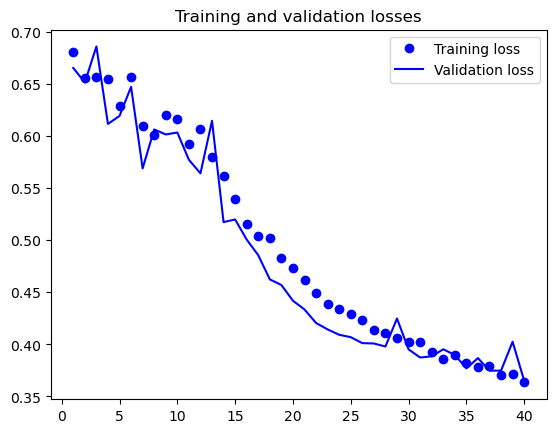

In [57]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

In [58]:
history

{'accuracy': [0.5959,
  0.607,
  0.55425,
  0.69695,
  0.69115,
  0.52515,
  0.71195,
  0.6841,
  0.7098,
  0.6896,
  0.71735,
  0.7298,
  0.70715,
  0.75225,
  0.73215,
  0.76555,
  0.78185,
  0.79295,
  0.7901,
  0.7936,
  0.7982,
  0.81755,
  0.81765,
  0.8193,
  0.82885,
  0.8303,
  0.82965,
  0.83505,
  0.8134,
  0.8407,
  0.84445,
  0.84545,
  0.8428,
  0.8524,
  0.85285,
  0.8519,
  0.85675,
  0.86005,
  0.8516,
  0.86525],
 'loss': [0.6810788499832153,
  0.6553339869499206,
  0.6565209032058715,
  0.6547321123600006,
  0.6286454539299011,
  0.6571375535488129,
  0.6097727672576905,
  0.6009738718986511,
  0.6198967350959778,
  0.6162342098712921,
  0.5920503124237061,
  0.6065264667510987,
  0.5798568341732026,
  0.5612049082756042,
  0.5399220766544343,
  0.5158945281028747,
  0.5044824436187744,
  0.5021460038661957,
  0.4833267044067383,
  0.47301871392726896,
  0.4615433275699615,
  0.449230460691452,
  0.4389232590198517,
  0.4343623802185059,
  0.4293676433086395,
  0.423

## Evaluation

In [59]:
torch.sum(torch.argmax(batch_inference(model, X_test), dim=-1) == y_test)/y_test.size()[0]

tensor(0.8322)

In [60]:
torch.save(model.state_dict(), 'classification_embs.pth')

In [61]:
# tensor(0.8375) nontrainable
# tensor(0.7852) trainable